## Setup

Load libraries:

In [1]:
import shap
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew
from matplotlib import pyplot as plt
from snowmodels.utils import compare_multiple_models

/home/habeeb/miniconda3/envs/ml_density_env/lib/python3.11/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
with open('../data/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

## Load predictions

In [3]:
density_predictions=(
    pd.concat([
        pd.read_parquet('../results/density/statistical_models_predictions.parquet'),
        pd.read_parquet('../results/density/ML_models_predictions_baseline.parquet')
    ], axis=1)
)

all_density_predictions=pd.concat([density_predictions,  pd.read_parquet('../results/density/ML_models_predictions_climate.parquet')], axis=1)

all_density_predictions.head()

,Snow_Class,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,EXT_Density,RF_Density,LGBM_Density,XGB_Density,EXT_Density_climate,RF_Density_climate,LGBM_Density_climate,XGB_Density_climate
0,Prairie,0.308333,0.222326,0.323,0.251437,0.274272,0.247755,0.254605,0.258287,0.266471,0.247584,0.239944,0.240130
1,Prairie,0.264286,0.224713,0.324,0.255262,0.270857,0.248233,0.256336,0.260336,0.266803,0.247646,0.238482,0.239190
2,Prairie,0.300000,0.223519,0.325,0.254935,0.277096,0.248691,0.263672,0.267221,0.268182,0.247646,0.242394,0.244625
3,Prairie,0.300000,0.223519,0.326,0.255984,0.279963,0.259595,0.267992,0.270378,0.269955,0.247646,0.246544,0.249720
4,Prairie,0.278571,0.224713,0.327,0.258397,0.278483,0.266122,0.270703,0.271092,0.270879,0.247646,0.249270,0.250659


In [5]:
all_density_predictions.isnull().sum()

Snow_Class                  0
Observed_Density            0
Jonas_Density           13930
Pistochi_Density            0
Sturm_Density           19502
EXT_Density                 0
RF_Density                  0
LGBM_Density                0
XGB_Density                 0
EXT_Density_climate         0
RF_Density_climate          0
LGBM_Density_climate        0
XGB_Density_climate         0
dtype: int64

In [6]:
all_density_predictions.shape, all_density_predictions.dropna().shape

((534818, 13), (502248, 13))

In [8]:
502248/534818

0.9391007782086617

In [7]:
(534818 - 502248)/534818

0.06089922179133836

In [6]:
float(data_splits.y_temp.mean())

0.3027827951087376

In [10]:
all_density_predictions=all_density_predictions.assign(Baseline_density = float(data_splits.y_temp.mean()))

In [27]:
all_swe_predictions.dropna().shape, all_density_predictions.dropna().shape

((442023, 14), (502248, 13))

In [9]:
swe_predictions=(
    pd.concat([
        pd.read_parquet('../results/swe/statistical_models_predictions.parquet'),
        pd.read_parquet('../results/swe/ML_models_predictions_baseline.parquet')
    ], axis=1)
)

all_swe_predictions=pd.concat([swe_predictions,  pd.read_parquet('../results/swe/ML_models_predictions_climate.parquet')], axis=1)
all_swe_predictions.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,EXT_SWE,RF_SWE,LGBM_SWE,XGB_SWE,EXT_SWE_climate,RF_SWE_climate,LGBM_SWE_climate,XGB_SWE_climate
0,Prairie,9.398,6.776484,7.663798,9.84504,NaN,8.359807,7.551563,7.760360,7.872575,8.122034,7.546353,7.313485,7.319155
1,Prairie,9.398,7.990801,9.077107,11.52144,NaN,9.631689,8.827179,9.115292,9.257566,9.487531,8.806277,8.480415,8.505586
2,Prairie,9.906,7.380611,8.417954,10.73150,NaN,9.149716,8.211768,8.706452,8.823651,8.855378,8.177257,8.003835,8.077516
3,Prairie,9.906,7.380611,8.452608,10.76452,NaN,9.244391,8.571824,8.849098,8.927877,8.913913,8.177257,8.140875,8.245748
4,Prairie,9.906,7.990801,9.188611,11.62812,NaN,9.902841,9.463315,9.626202,9.640039,9.632469,8.806277,8.864030,8.913432


In [11]:
all_swe_predictions=all_swe_predictions.assign(Baseline_SWE = float(data_splits.y_temp.mean())*data_splits.X_test.Snow_Depth.values)

## Model Comparison

### Density

* Overall

In [12]:
density_df_for_evals = (
    all_density_predictions.drop('Snow_Class', axis=1)
    .filter(items=[
        'LGBM_Density_climate', 'LGBM_Density',
        'Jonas_Density', 'Sturm_Density', 'Pistochi_Density', 'Baseline_density', 'Observed_Density'
    ])
    .rename(columns={'Pistochi_Density': 'Pistocchi_Density'})
    .dropna()
)

density_eval_results=compare_multiple_models(preds_df=density_df_for_evals, y_true="Observed_Density")
# density_eval_results.to_csv('../results/density/all_model_eval_results.csv', index=True)
density_eval_results

,LGBM_Density_climate,LGBM_Density,Jonas_Density,Sturm_Density,Pistocchi_Density,Baseline_density
RMSE,0.046977,0.050139,0.065961,0.080009,0.096244,0.088806
MBE,0.002503,0.002134,-0.007745,-0.008246,0.069046,0.004265
RSQ,0.719527,0.680502,0.447042,0.186429,-0.177235,-0.002312


In [13]:
(0.065961 - 0.050139)/0.065961, (0.096244 - 0.050139)/0.096244

(0.239869013507982, 0.47904284942437964)

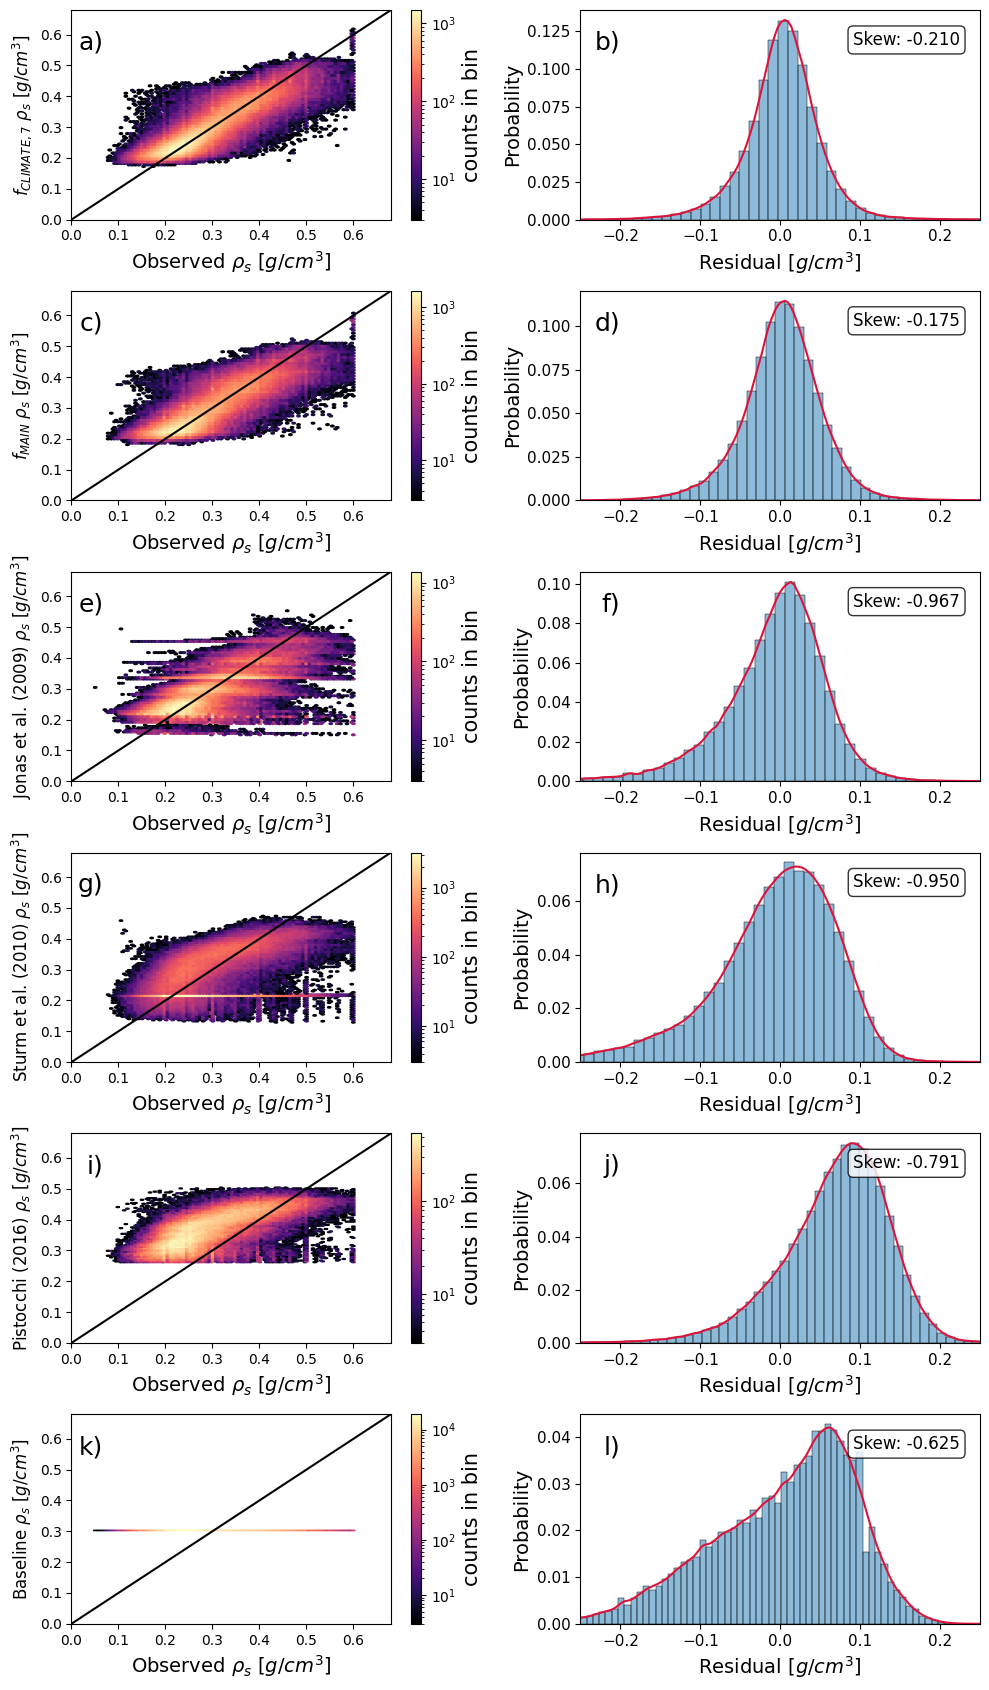

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skew

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 17))

for i, model in enumerate(density_df_for_evals.columns[:-1]):
    
    if model == 'LGBM_Density':
        y_label = r'$f_{MAIN}\ \rho_s\ [g/cm^3]$'
    elif model == 'LGBM_Density_climate':
        y_label = r'$f_{CLIMATE, 7}\ \rho_s\ [g/cm^3]$'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. (2009)' + r' $\rho_s\  [g/cm^3]$'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. (2010)' + r' $\rho_s\  [g/cm^3]$'
    elif 'Pistocchi' in model:
        y_label = 'Pistocchi (2016)' + r' $\rho_s\  [g/cm^3]$'
    else:
        y_label = model.split('_')[0] + r' $\rho_s\  [g/cm^3]$'
    
    # Left panel: hexbin plot
    hb = ax[i, 0].hexbin(density_df_for_evals.Observed_Density, 
                         density_df_for_evals[model], 
                         gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
    ax[i, 0].set_xlabel(r'Observed $\rho_s\ [g/cm^3]$', fontsize=14)
    ax[i, 0].set_ylabel(y_label, fontsize=12)
    ax[i, 0].set(xlim=(0, 0.68), ylim=(0, 0.68))
    ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', 
                  transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
    cb = plt.colorbar(hb, ax=ax[i, 0])
    cb.set_label('counts in bin', fontsize=15)
    
    # Right panel: residual histogram with skewness
    residuals = density_df_for_evals[model] - density_df_for_evals.Observed_Density
    residual_skewness = skew(residuals.dropna())  # Remove NaN values before calculating skewness
    
    sns.histplot(residuals, kde=True, stat='probability', bins=70, ax=ax[i, 1])
    ax[i, 1].lines[0].set_color('crimson')
    ax[i, 1].set_xlabel('Residual $[g/cm^3]$', fontsize=14)
    ax[i, 1].set_ylabel('Probability', fontsize=14)
    ax[i, 1].set(xlim=(-0.25, 0.25))
    ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', 
                  transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    
    # Add skewness text
    ax[i, 1].text(0.95, 0.90, f'Skew: {residual_skewness:.3f}', 
                  transform=ax[i, 1].transAxes, fontsize=12, 
                  va='top', ha='right', 
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax[i, 1].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('../plots/figure7.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

def comprehensive_residual_analysis_density(density_df_for_evals):
    """
    Comprehensive analysis of density residual distributions
    """
    results = []
    
    # Define the model columns (exclude 'Observed_Density')
    model_columns = ['LGBM_Density', 'LGBM_Density_climate', 'Jonas_Density', 
                    'Sturm_Density', 'Pistocchi_Density', 'Baseline_density']
    
    for model in model_columns:
        residuals = density_df_for_evals[model] - density_df_for_evals.Observed_Density
        residuals_clean = residuals.dropna()
        
        # Basic statistics
        stats = {
            'Model': model,
            'Mean_Residual': np.mean(residuals_clean),
            'Std_Residual': np.std(residuals_clean),
            'MAE': np.mean(np.abs(residuals_clean)),
            'RMSE': np.sqrt(np.mean(residuals_clean**2)),
            'Skewness': skew(residuals_clean),
            'Kurtosis': kurtosis(residuals_clean, fisher=True),
            # Percentile-based measures
            'IQR': np.percentile(residuals_clean, 75) - np.percentile(residuals_clean, 25),
            'P90_P10_Range': np.percentile(residuals_clean, 90) - np.percentile(residuals_clean, 10),
            'P95_P5_Range': np.percentile(residuals_clean, 95) - np.percentile(residuals_clean, 5),
            # Tail behavior (using smaller thresholds for density - g/cm³)
            'Extreme_Negative_Count': np.sum(residuals_clean < -0.10),  # Severe underestimation
            'Extreme_Positive_Count': np.sum(residuals_clean > 0.10),   # Severe overestimation
            'Within_0.05_Percent': np.sum(np.abs(residuals_clean) <= 0.05) / len(residuals_clean) * 100,
            'Within_0.10_Percent': np.sum(np.abs(residuals_clean) <= 0.10) / len(residuals_clean) * 100,
        }
        results.append(stats)
    
    df_results = pd.DataFrame(results)
    return df_results

def plot_distribution_widths_density(density_df_for_evals):
    """
    Plot to visualize density distribution widths
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    model_columns = ['LGBM_Density', 'LGBM_Density_climate', 'Jonas_Density', 
                    'Sturm_Density', 'Pistocchi_Density', 'Baseline_density']
    
    std_values = []
    iqr_values = []
    p90_p10_values = []
    model_names = []
    
    for model in model_columns:
        residuals = (density_df_for_evals[model] - density_df_for_evals.Observed_Density).dropna()
        std_values.append(np.std(residuals))
        iqr_values.append(np.percentile(residuals, 75) - np.percentile(residuals, 25))
        p90_p10_values.append(np.percentile(residuals, 90) - np.percentile(residuals, 10))
        
        # Clean up model names for display
        if model == 'LGBM_Density':
            display_name = 'f_MAIN'
        elif model == 'LGBM_Density_climate':
            display_name = 'f_CLIMATE'
        elif model == 'Baseline_Density':
            display_name = 'Baseline'
        else:
            display_name = model.replace('_Density', '')
        
        model_names.append(display_name)
    
    # Standard deviation
    axes[0,0].bar(range(len(model_names)), std_values)
    axes[0,0].set_title('Standard Deviation of Density Residuals')
    axes[0,0].set_ylabel('Std Dev [g/cm³]')
    axes[0,0].set_xticks(range(len(model_names)))
    axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
    
    # IQR (25th-75th percentile range)
    axes[0,1].bar(range(len(model_names)), iqr_values)
    axes[0,1].set_title('Interquartile Range (IQR)')
    axes[0,1].set_ylabel('IQR [g/cm³]')
    axes[0,1].set_xticks(range(len(model_names)))
    axes[0,1].set_xticklabels(model_names, rotation=45, ha='right')
    
    # 90th-10th percentile range
    axes[1,0].bar(range(len(model_names)), p90_p10_values)
    axes[1,0].set_title('90th-10th Percentile Range')
    axes[1,0].set_ylabel('P90-P10 Range [g/cm³]')
    axes[1,0].set_xticks(range(len(model_names)))
    axes[1,0].set_xticklabels(model_names, rotation=45, ha='right')
    
    # Precision vs Accuracy plot
    mae_values = [np.mean(np.abs((density_df_for_evals[model] - density_df_for_evals.Observed_Density).dropna())) 
                  for model in model_columns]
    
    axes[1,1].scatter(mae_values, std_values, s=100)
    for i, name in enumerate(model_names):
        axes[1,1].annotate(name, (mae_values[i], std_values[i]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_xlabel('Mean Absolute Error (Accuracy) [g/cm³]')
    axes[1,1].set_ylabel('Standard Deviation (Precision) [g/cm³]')
    axes[1,1].set_title('Accuracy vs Precision - Density')
    
    plt.tight_layout()
    plt.show()

def analyze_extreme_errors_density(density_df_for_evals, model_name, threshold=0.10):
    """
    Analyze when density models produce extreme errors
    """
    residuals = density_df_for_evals[model_name] - density_df_for_evals.Observed_Density
    
    # Find extreme positive errors (severe overestimation)
    extreme_over = density_df_for_evals[residuals < -threshold]
    
    # Find extreme negative errors (severe underestimation)  
    extreme_under = density_df_for_evals[residuals > threshold]
    
    print(f"\n{model_name} - Extreme Error Analysis:")
    print(f"Severe overestimation (>{threshold} g/cm³): {len(extreme_over)} cases")
    if len(extreme_over) > 0:
        print(f"  - Observed density range: {extreme_over.Observed_Density.min():.3f} to {extreme_over.Observed_Density.max():.3f} g/cm³")
    
    print(f"Severe underestimation (>{threshold} g/cm³): {len(extreme_under)} cases")  
    if len(extreme_under) > 0:
        print(f"  - Observed density range: {extreme_under.Observed_Density.min():.3f} to {extreme_under.Observed_Density.max():.3f} g/cm³")
    
    return extreme_over, extreme_under

# Example usage:
# results_df = comprehensive_residual_analysis_density(density_df_for_evals)
# print(results_df.round(4))
# plot_distribution_widths_density(density_df_for_evals)
# extreme_over, extreme_under = analyze_extreme_errors_density(density_df_for_evals, 'Jonas_Density')

results_df = comprehensive_residual_analysis_density(density_df_for_evals)
print(results_df.round(4))

                  Model  Mean_Residual  Std_Residual     MAE    RMSE  \
0          LGBM_Density         0.0021        0.0501  0.0374  0.0501   
1  LGBM_Density_climate         0.0025        0.0469  0.0344  0.0470   
2         Jonas_Density        -0.0077        0.0655  0.0480  0.0660   
3         Sturm_Density        -0.0082        0.0796  0.0602  0.0800   
4     Pistocchi_Density         0.0690        0.0670  0.0830  0.0962   
5      Baseline_density         0.0043        0.0887  0.0728  0.0888   

   Skewness  Kurtosis     IQR  P90_P10_Range  P95_P5_Range  \
0   -0.1753    2.2994  0.0574         0.1175        0.1596   
1   -0.2098    3.0854  0.0510         0.1073        0.1486   
2   -0.9671    3.0110  0.0737         0.1513        0.2060   
3   -0.9496    1.5981  0.0960         0.1923        0.2585   
4   -0.7909    1.7288  0.0827         0.1629        0.2134   
5   -0.6246   -0.0446  0.1243         0.2250        0.2869   

   Extreme_Negative_Count  Extreme_Positive_Count  Within_0.

In [19]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from scipy.stats import skew, kurtosis

# fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 17))

# for i, model in enumerate(density_df_for_evals.columns[:-1]):
    
#     if model == 'LGBM_Density':
#         y_label = r'$f_{MAIN}\ \rho_s\ [g/cm^3]$'
#     elif model == 'LGBM_Density_climate':
#         y_label = r'$f_{CLIMATE}\ \rho_s\ [g/cm^3]$'
#     elif 'Jonas' in model:
#         y_label = 'Jonas et al. (2009)' + r' $\rho_s\  [g/cm^3]$'
#     elif 'Sturm' in model:
#         y_label = 'Sturm et al. (2010)' + r' $\rho_s\  [g/cm^3]$'
#     elif 'Pistocchi' in model:
#         y_label = 'Pistocchi (2016)' + r' $\rho_s\  [g/cm^3]$'
#     else:
#         y_label = model.split('_')[0] + r' $\rho_s\  [g/cm^3]$'
    
#     # Left panel: hexbin plot
#     hb = ax[i, 0].hexbin(density_df_for_evals.Observed_Density, 
#                          density_df_for_evals[model], 
#                          gridsize=80, cmap='magma', bins='log', mincnt=5)
#     ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
#     ax[i, 0].set_xlabel(r'Observed $\rho_s\ [g/cm^3]$', fontsize=14)
#     ax[i, 0].set_ylabel(y_label, fontsize=12)
#     ax[i, 0].set(xlim=(0, 0.68), ylim=(0, 0.68))
#     ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', 
#                   transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
#     cb = plt.colorbar(hb, ax=ax[i, 0])
#     cb.set_label('counts in bin', fontsize=15)
    
#     # Right panel: residual histogram with skewness and kurtosis
#     residuals = density_df_for_evals[model] - density_df_for_evals.Observed_Density
#     residual_skewness = skew(residuals.dropna())
#     residual_kurtosis = kurtosis(residuals.dropna(), fisher=True)
    
#     sns.histplot(residuals, kde=True, stat='probability', bins=70, ax=ax[i, 1])
#     ax[i, 1].lines[0].set_color('crimson')
#     ax[i, 1].set_xlabel(r'Residual $[g/cm^3]$', fontsize=14)
#     ax[i, 1].set_ylabel('Probability', fontsize=14)
#     ax[i, 1].set(xlim=(-0.25, 0.25))
#     ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', 
#                   transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    
#     # Add skewness and kurtosis text
#     stats_text = f'Skew: {residual_skewness:.3f}\nKurt: {residual_kurtosis:.3f}'
#     ax[i, 1].text(0.95, 0.90, stats_text, 
#                   transform=ax[i, 1].transAxes, fontsize=11, 
#                   va='top', ha='right', 
#                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
#     ax[i, 1].tick_params(labelsize=11)

# plt.tight_layout()
# plt.savefig('../plots/figure7.jpg', dpi=300, bbox_inches='tight')
# plt.show()

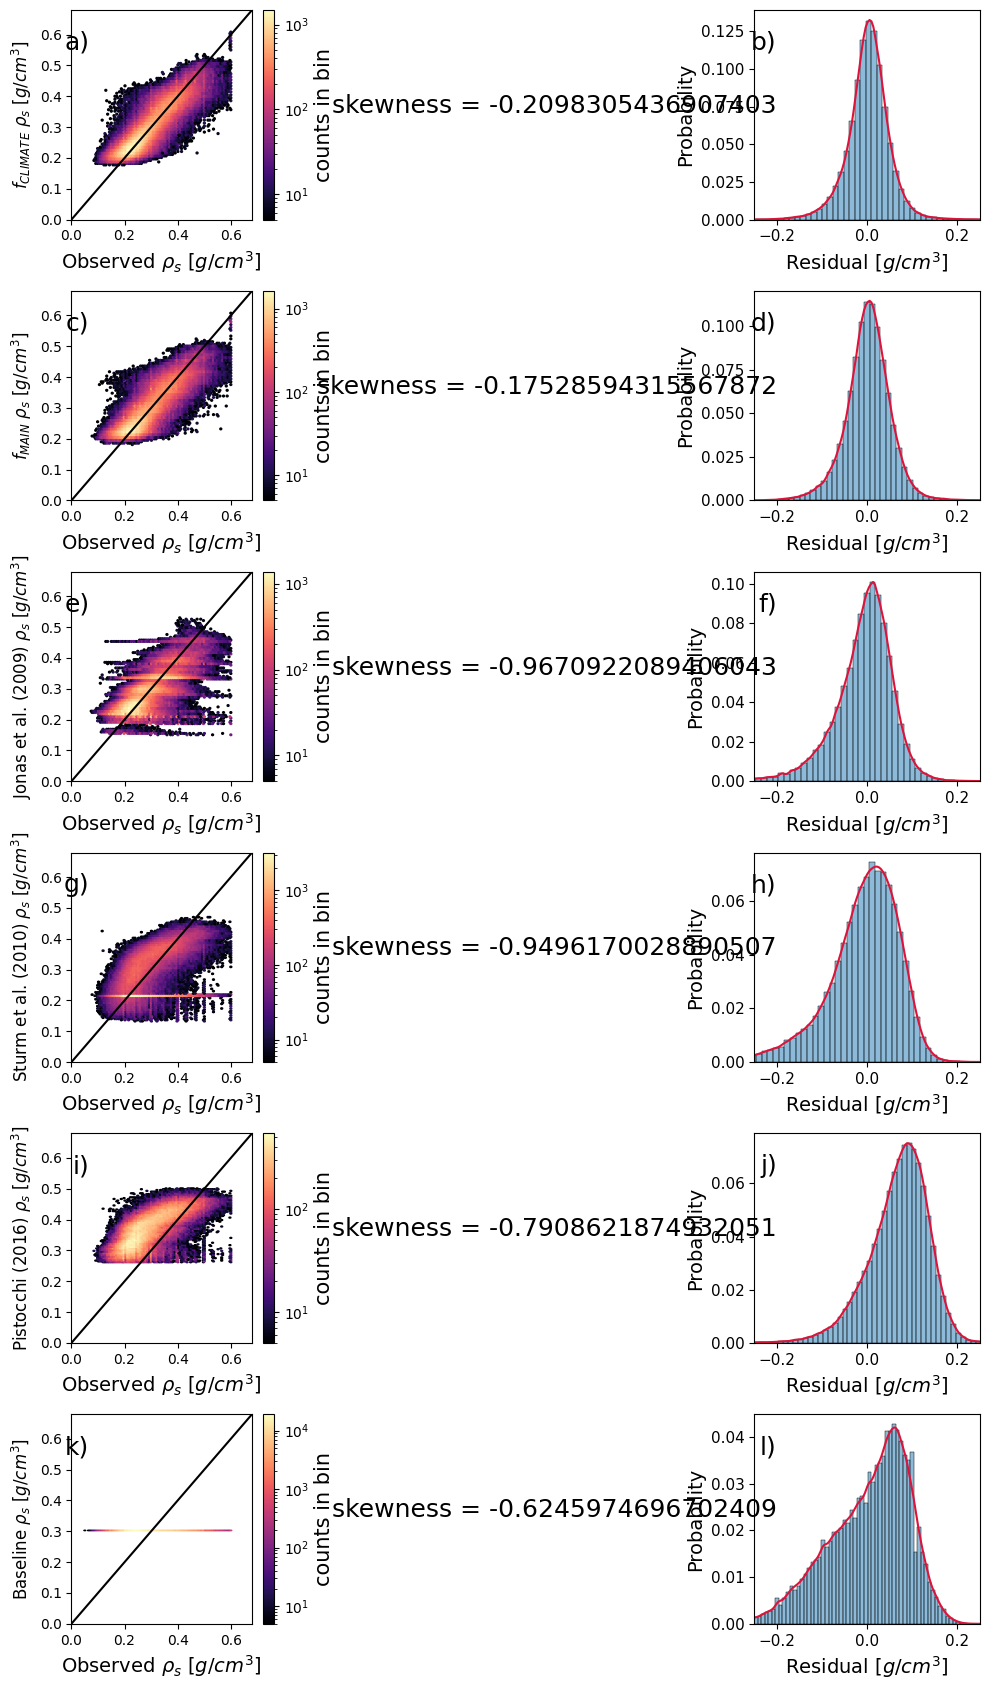

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 17))

for i, model in enumerate(density_df_for_evals.columns[:-1]):

    if model == 'LGBM_Density':
        y_label = r'$f_{MAIN}\ \rho_s\ [g/cm^3]$'
    elif model == 'LGBM_Density_climate':
        y_label = r'$f_{CLIMATE}\ \rho_s\ [g/cm^3]$'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. (2009)' + r' $\rho_s\  [g/cm^3]$'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. (2010)' + r' $\rho_s\  [g/cm^3]$'
    elif 'Pistocchi' in model:
        y_label = 'Pistocchi (2016)' + r' $\rho_s\  [g/cm^3]$'
    else:
        y_label = model.split('_')[0] + r' $\rho_s\  [g/cm^3]$'

    hb = ax[i, 0].hexbin(density_df_for_evals.Observed_Density, density_df_for_evals[model], gridsize=80, cmap='magma', bins='log', mincnt=5)
    ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
    ax[i, 0].set_xlabel(r'Observed $\rho_s\ [g/cm^3]$', fontsize=14)
    ax[i, 0].set_ylabel(y_label, fontsize=12)
    ax[i, 0].set(xlim=(0, 0.68), ylim=(0, 0.68))
    ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
    cb = plt.colorbar(hb)
    cb.set_label('counts in bin', fontsize=15)

    sns.histplot(density_df_for_evals[model] - density_df_for_evals.Observed_Density, kde=True, stat='probability', bins=70, ax=ax[i, 1])
    ax[i, 1].lines[0].set_color('crimson')
    ax[i, 1].set_xlabel('Residual $[g/cm^3]$', fontsize=14)
    ax[i, 1].set_ylabel('Probability', fontsize=14)
    ax[i, 1].set(xlim=(-0.25, 0.25))
    ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    # ax[i, 1].text(0.10, 0.60, f'skewness = {skew(density_df_for_evals[model] - density_df_for_evals.Observed_Density)}', transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    ax[i, 1].tick_params(labelsize=11)

plt.tight_layout()
# plt.savefig('../plots/figure7.jpg', dpi=300, bbox_inches='tight')
plt.show()

* Evaluate by Snow Class

In [20]:
for snow_class in all_density_predictions.Snow_Class.unique():

    # Filter the DataFrame for the current snow class and drop NaNs
    if snow_class != "Ephemeral":
        density_df_for_evals_ = (
            all_density_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'LGBM_Density_climate', 'LGBM_Density', 'Jonas_Density', 'Sturm_Density',
                'Pistochi_Density', 'Baseline_density', 'Observed_Density'
            ])
            .dropna()
        )
    else:
        density_df_for_evals_ = (
            all_density_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'LGBM_Density_climate', 'LGBM_Density', 'Jonas_Density',
                'Pistochi_Density', 'Baseline_density', 'Observed_Density'
            ])
            .dropna()
        )


    # Calculate the size and percentage of the test set
    size = density_df_for_evals_.shape[0]
    total_size = all_density_predictions.dropna().shape[0] + all_density_predictions.query("Snow_Class == 'Ephemeral'").drop('Sturm_Density', axis=1).dropna().shape[0]
    percentage = round(size / total_size * 100, 1)

    # Print the snow class and the size of the test set
    print(f"Snow Class: {snow_class}, Test Set Size: {size} ({percentage}%)")

    rslts=compare_multiple_models(preds_df=density_df_for_evals_, y_true="Observed_Density")

    if snow_class == "Ephemeral":
        display(rslts.assign(Sturm_Density='N/A'))
    # rslts.to_csv(f'../results/density/{snow_class}_model_eval.csv', index=True)
    # Display the results of comparing multiple models
    else:
        display(rslts)


Snow Class: Prairie, Test Set Size: 39343 (7.6%)


,LGBM_Density_climate,LGBM_Density,Jonas_Density,Sturm_Density,Pistochi_Density,Baseline_density
RMSE,0.048399,0.050884,0.066151,0.072291,0.097139,0.085751
MBE,0.009098,0.006328,-0.014444,0.017341,0.073485,0.013423
RSQ,0.673436,0.639037,0.389942,0.271428,-0.315494,-0.025118


Snow Class: Alpine, Test Set Size: 281416 (54.1%)


,LGBM_Density_climate,LGBM_Density,Jonas_Density,Sturm_Density,Pistochi_Density,Baseline_density
RMSE,0.046384,0.049573,0.062701,0.069778,0.096413,0.085084
MBE,0.002233,0.002461,-0.008165,0.012390,0.073530,0.010757
RSQ,0.697975,0.655022,0.448108,0.316503,-0.304888,-0.016244


Snow Class: Ephemeral, Test Set Size: 18337 (3.5%)


,LGBM_Density_climate,LGBM_Density,Jonas_Density,Pistochi_Density,Baseline_density,Sturm_Density
RMSE,0.062102,0.067838,0.106666,0.079942,0.098687,N/A
MBE,0.001333,0.001293,-0.068098,0.023006,-0.035321,N/A
RSQ,0.545827,0.458046,-0.339883,0.247412,-0.146916,N/A


Snow Class: Maritime, Test Set Size: 62727 (12.0%)


,LGBM_Density_climate,LGBM_Density,Jonas_Density,Sturm_Density,Pistochi_Density,Baseline_density
RMSE,0.059277,0.063259,0.091681,0.077665,0.071342,0.113883
MBE,-0.003349,-0.004085,-0.050579,-0.018949,0.005791,-0.062482
RSQ,0.612399,0.558578,0.072804,0.334634,0.438563,-0.430655


Snow Class: Taiga, Test Set Size: 109312 (21.0%)


,LGBM_Density_climate,LGBM_Density,Jonas_Density,Sturm_Density,Pistochi_Density,Baseline_density
RMSE,0.040065,0.042908,0.054065,0.105533,0.103428,0.082277
MBE,0.004348,0.003582,0.015716,-0.068350,0.087473,0.017433
RSQ,0.751733,0.715248,0.547913,-0.722538,-0.654504,-0.047005


Snow Class: Tundra, Test Set Size: 9450 (1.8%)


,LGBM_Density_climate,LGBM_Density,Jonas_Density,Sturm_Density,Pistochi_Density,Baseline_density
RMSE,0.039698,0.042298,0.079626,0.067862,0.136674,0.092541
MBE,0.000584,-0.000519,0.045568,0.036989,0.123767,0.063563
RSQ,0.651613,0.604495,-0.401610,-0.018054,-3.129448,-0.893147


In [22]:
density_for_boxplot=(
    all_density_predictions
    .filter(items=[
        'Observed_Density', 'LGBM_Density_climate', 'LGBM_Density', 'Jonas_Density', 'Sturm_Density', 'Pistochi_Density', 'Baseline_density', 'Snow_Class'
    ])
    .dropna(subset=['LGBM_Density_climate', 'Jonas_Density'])
    .melt(id_vars=['Snow_Class'], value_vars=['Observed_Density', 'LGBM_Density_climate', 'LGBM_Density', 'Jonas_Density', 'Sturm_Density', 'Pistochi_Density', 'Baseline_density'], var_name='Model', value_name='Density')
    .replace({'LGBM_Density_climate': '$f_{CLIMATE}$', 'LGBM_Density': '$f_{MAIN}$', 'Observed_Density': 'Observed'})
)

density_for_boxplot.head()

,Snow_Class,Model,Density
0,Prairie,Observed,0.308333
1,Prairie,Observed,0.264286
2,Prairie,Observed,0.300000
3,Prairie,Observed,0.300000
4,Prairie,Observed,0.278571


#### SWE

* Overall

In [23]:
swe_df_for_evals = (
    all_swe_predictions.drop('Snow_Class', axis=1)
    .filter(items=[
        'LGBM_SWE_climate', 'LGBM_SWE',
        'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE', 'Baseline_SWE', 'Observed_SWE'
    ])
    .dropna()
)

swe_evals_results=compare_multiple_models(preds_df=swe_df_for_evals, y_true="Observed_SWE")
# swe_evals_results.to_csv('../results/swe/all_model_eval_results.csv', index=True)
swe_evals_results

,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE
RMSE,4.329780,4.825022,6.237857,9.629859,9.593239,11.913403,10.020191
MBE,0.316507,0.276961,0.179509,-0.532970,6.699927,6.664933,-0.943429
RSQ,0.973834,0.967506,0.945690,0.870567,0.871549,0.801903,0.859861


In [24]:
(11.913403 - 4.825022)/11.913403

0.594992127774071

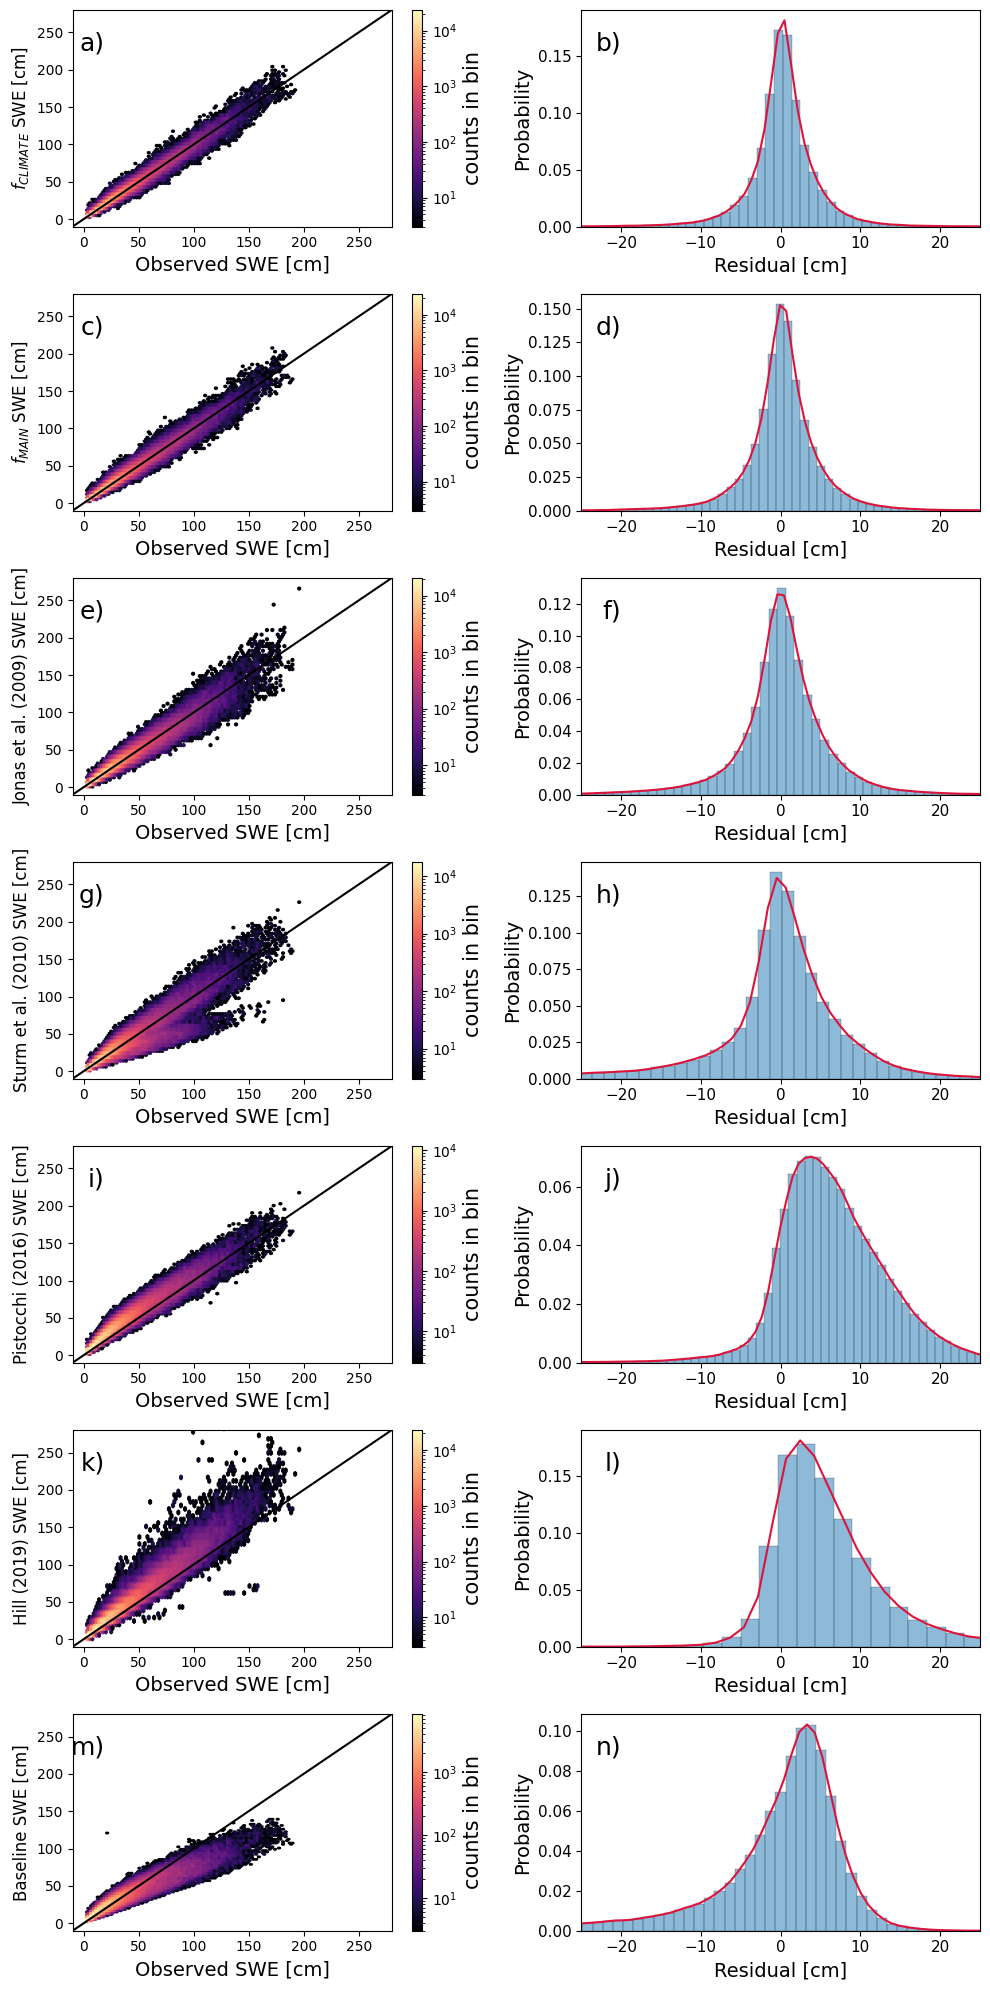

In [ ]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10, 20))

for i, model in enumerate(swe_df_for_evals.columns[:-1]):

    if model == 'LGBM_SWE':
        y_label = '$f_{MAIN}$' + ' SWE [cm]'
    elif model == 'LGBM_SWE_climate':
        y_label = '$f_{CLIMATE}$' + ' SWE [cm]'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. (2009)' + ' SWE [cm]'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. (2010)' + ' SWE [cm]'
    elif 'Pistochi' in model:
        y_label = 'Pistocchi (2016)' + ' SWE [cm]' 
    elif 'Hill' in model:
        y_label = 'Hill (2019)' + ' SWE [cm]'
    else:
        y_label = model.split('_')[0] + ' SWE [cm]'

    hb = ax[i, 0].hexbin(swe_df_for_evals.Observed_SWE, swe_df_for_evals[model], gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
    ax[i, 0].set_xlabel('Observed SWE [cm]', fontsize=14)
    ax[i, 0].set_ylabel(y_label, fontsize=12)
    # ax[i, 0].set_aspect('equal', 'box')#.axis('equal')
    # ax[i, 0].axis('equal')
    ax[i, 0].set(xlim=(-10, 280), ylim=(-10, 280))
    ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
    cb = plt.colorbar(hb)
    cb.set_label('counts in bin', fontsize=15)

    sns.histplot(swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE, kde=True, stat='probability', bins=150, ax=ax[i, 1])
    ax[i, 1].lines[0].set_color('crimson')
    ax[i, 1].set_xlabel('Residual [cm]', fontsize=14)
    ax[i, 1].set_ylabel('Probability', fontsize=14)
    ax[i, 1].set(xlim=(-25, 25))
    ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    ax[i, 1].tick_params(labelsize=11)

plt.tight_layout()
# plt.savefig('../plots/figure8.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
swe_df_for_evals.columns

Index(['LGBM_SWE_climate', 'LGBM_SWE', 'Jonas_SWE', 'Sturm_SWE',
       'Pistochi_SWE', 'Hill_SWE', 'Baseline_SWE', 'Observed_SWE'],
      dtype='object')

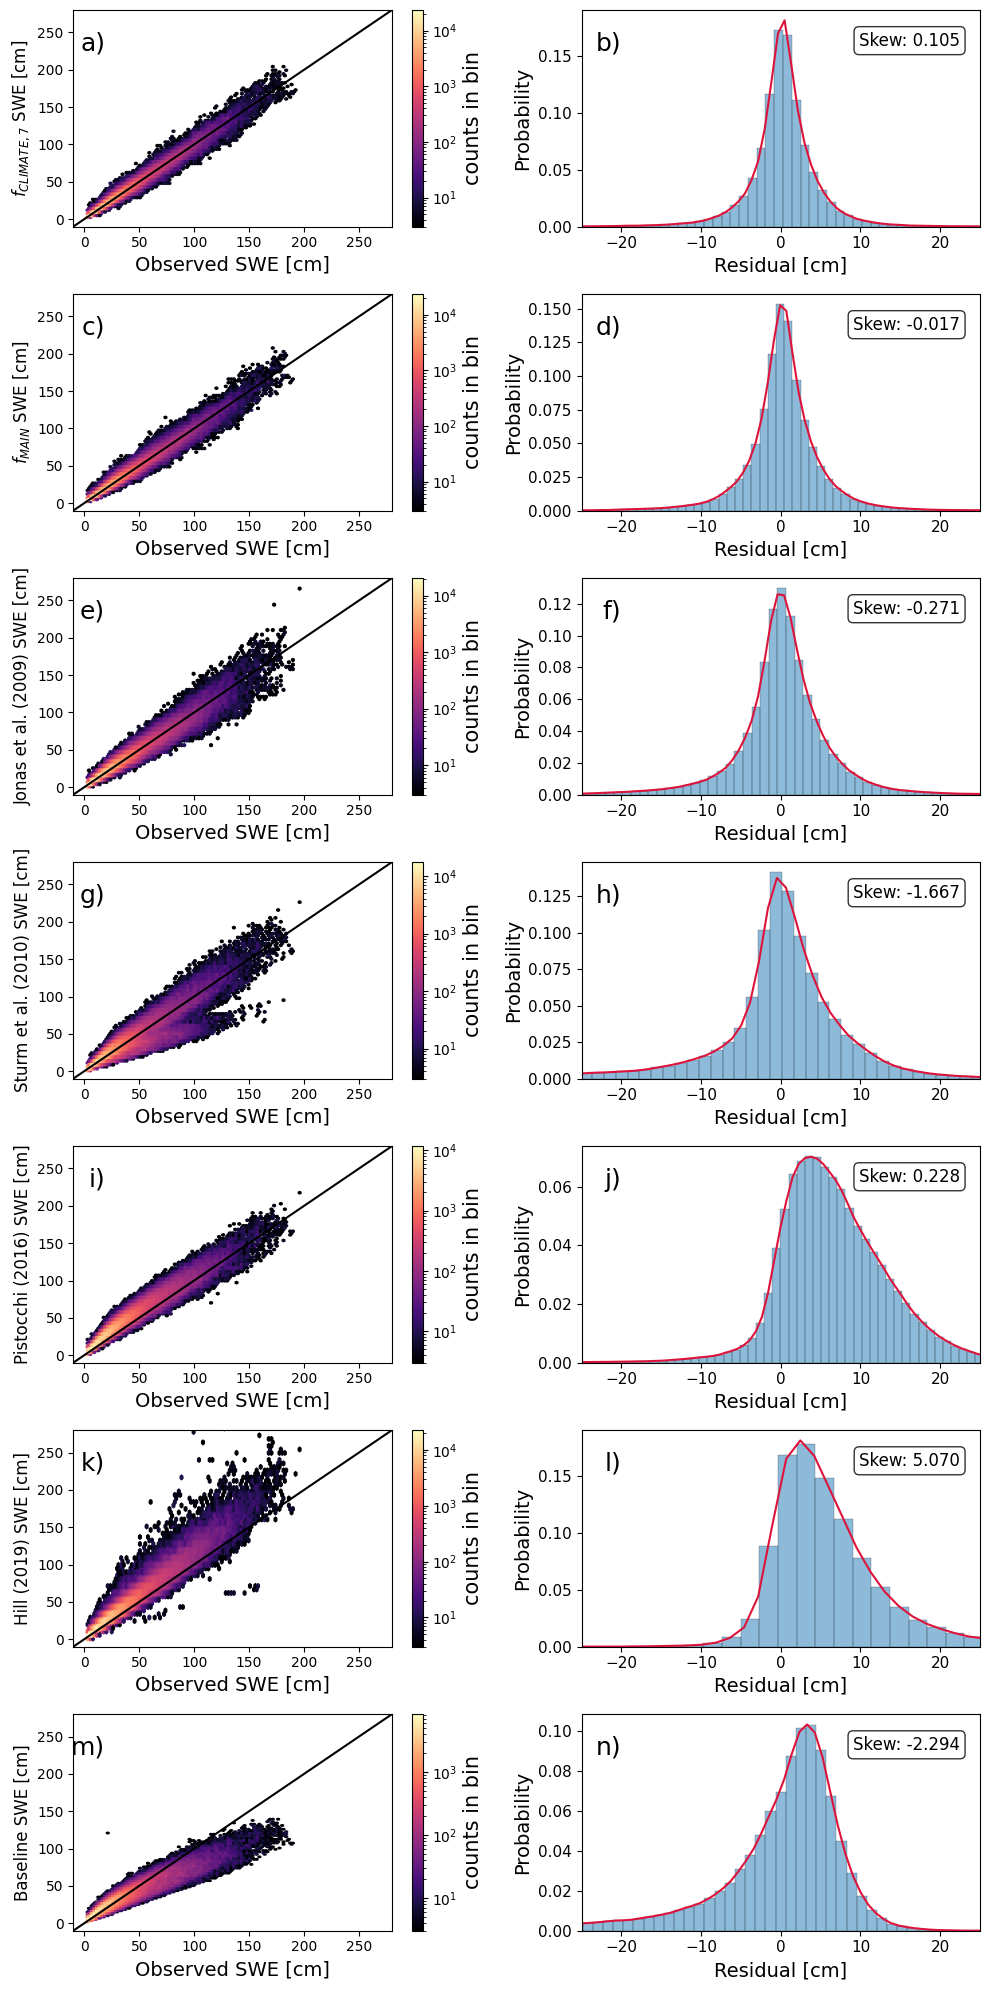

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skew

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10, 20))

for i, model in enumerate(swe_df_for_evals.columns[:-1]):

    if model == 'LGBM_SWE':
        y_label = '$f_{MAIN}$' + ' SWE [cm]'
    elif model == 'LGBM_SWE_climate':
        y_label = '$f_{CLIMATE, 7}$' + ' SWE [cm]'
    elif 'Jonas' in model:
        y_label = 'Jonas et al. (2009)' + ' SWE [cm]'
    elif 'Sturm' in model:
        y_label = 'Sturm et al. (2010)' + ' SWE [cm]'
    elif 'Pistochi' in model:
        y_label = 'Pistocchi (2016)' + ' SWE [cm]' 
    elif 'Hill' in model:
        y_label = 'Hill (2019)' + ' SWE [cm]'
    else:
        y_label = model.split('_')[0] + ' SWE [cm]'

    # Left panel: hexbin plot
    hb = ax[i, 0].hexbin(swe_df_for_evals.Observed_SWE, swe_df_for_evals[model], 
                         gridsize=80, cmap='magma', bins='log', mincnt=3)
    ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
    ax[i, 0].set_xlabel('Observed SWE [cm]', fontsize=14)
    ax[i, 0].set_ylabel(y_label, fontsize=12)
    ax[i, 0].set(xlim=(-10, 280), ylim=(-10, 280))
    ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', 
                  transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
    cb = plt.colorbar(hb, ax=ax[i, 0])
    cb.set_label('counts in bin', fontsize=15)

    # Right panel: residual histogram with skewness
    residuals = swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE
    residual_skewness = skew(residuals.dropna())
    
    sns.histplot(residuals, kde=True, stat='probability', bins=150, ax=ax[i, 1])
    ax[i, 1].lines[0].set_color('crimson')
    ax[i, 1].set_xlabel('Residual [cm]', fontsize=14)
    ax[i, 1].set_ylabel('Probability', fontsize=14)
    ax[i, 1].set(xlim=(-25, 25))
    ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', 
                  transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    
    # Add skewness text
    ax[i, 1].text(0.95, 0.90, f'Skew: {residual_skewness:.3f}', 
                  transform=ax[i, 1].transAxes, fontsize=12, 
                  va='top', ha='right', 
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax[i, 1].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('../plots/figure8.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
swe_df_for_evals.columns

Index(['LGBM_SWE_climate', 'LGBM_SWE', 'Jonas_SWE', 'Sturm_SWE',
       'Pistochi_SWE', 'Hill_SWE', 'Baseline_SWE', 'Observed_SWE'],
      dtype='object')

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

def comprehensive_residual_analysis(swe_df_for_evals):
    """
    Comprehensive analysis of residual distributions
    """
    results = []
    
    for model in swe_df_for_evals.columns[:-1]:  # Exclude observed column
        residuals = swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE
        residuals_clean = residuals.dropna()
        
        # Basic statistics
        stats = {
            'Model': model,
            'Mean_Residual': np.mean(residuals_clean),
            'Std_Residual': np.std(residuals_clean),
            'MAE': np.mean(np.abs(residuals_clean)),
            'RMSE': np.sqrt(np.mean(residuals_clean**2)),
            'Skewness': skew(residuals_clean),
            'Kurtosis': kurtosis(residuals_clean, fisher=True),
            # Percentile-based measures
            'IQR': np.percentile(residuals_clean, 75) - np.percentile(residuals_clean, 25),
            'P90_P10_Range': np.percentile(residuals_clean, 90) - np.percentile(residuals_clean, 10),
            'P95_P5_Range': np.percentile(residuals_clean, 95) - np.percentile(residuals_clean, 5),
            # Tail behavior
            'Extreme_Negative_Count': np.sum(residuals_clean < -15),  # Severe underestimation
            'Extreme_Positive_Count': np.sum(residuals_clean > 15),   # Severe overestimation
            'Within_5cm_Percent': np.sum(np.abs(residuals_clean) <= 5) / len(residuals_clean) * 100,
            'Within_10cm_Percent': np.sum(np.abs(residuals_clean) <= 10) / len(residuals_clean) * 100,
        }
        results.append(stats)
    
    df_results = pd.DataFrame(results)
    return df_results

# Example usage:
# results_df = comprehensive_residual_analysis(swe_df_for_evals)
# print(results_df.round(3))

def plot_distribution_widths(swe_df_for_evals):
    """
    Plot to visualize distribution widths
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    models = swe_df_for_evals.columns[:-1]
    std_values = []
    iqr_values = []
    p90_p10_values = []
    model_names = []
    
    for model in models:
        residuals = (swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE).dropna()
        std_values.append(np.std(residuals))
        iqr_values.append(np.percentile(residuals, 75) - np.percentile(residuals, 25))
        p90_p10_values.append(np.percentile(residuals, 90) - np.percentile(residuals, 10))
        model_names.append(model.replace('LGBM_SWE', 'f_MAIN').replace('LGBM_SWE_climate', 'f_CLIMATE'))
    
    # Standard deviation
    axes[0,0].bar(range(len(model_columns)), std_values)
    axes[0,0].set_title('Standard Deviation of Residuals')
    axes[0,0].set_ylabel('Std Dev [cm]')
    axes[0,0].set_xticks(range(len(model_columns)))
    axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
    
    # IQR (25th-75th percentile range)
    axes[0,1].bar(range(len(model_columns)), iqr_values)
    axes[0,1].set_title('Interquartile Range (IQR)')
    axes[0,1].set_ylabel('IQR [cm]')
    axes[0,1].set_xticks(range(len(model_columns)))
    axes[0,1].set_xticklabels(model_names, rotation=45, ha='right')
    
    # 90th-10th percentile range
    axes[1,0].bar(range(len(model_columns)), p90_p10_values)
    axes[1,0].set_title('90th-10th Percentile Range')
    axes[1,0].set_ylabel('P90-P10 Range [cm]')
    axes[1,0].set_xticks(range(len(model_columns)))
    axes[1,0].set_xticklabels(model_names, rotation=45, ha='right')
    
    # Precision vs Accuracy plot
    mae_values = [np.mean(np.abs((swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE).dropna())) 
                  for model in model_columns]
    
    axes[1,1].scatter(mae_values, std_values, s=100)
    for i, name in enumerate(model_names):
        axes[1,1].annotate(name, (mae_values[i], std_values[i]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_xlabel('Mean Absolute Error (Accuracy) [cm]')
    axes[1,1].set_ylabel('Standard Deviation (Precision) [cm]')
    axes[1,1].set_title('Accuracy vs Precision')
    
    plt.tight_layout()
    plt.show()

# Example of how to identify problematic conditions
def analyze_extreme_errors(swe_df_for_evals, model_name, threshold=15):
    """
    Analyze when models produce extreme errors
    """
    residuals = swe_df_for_evals[model_name] - swe_df_for_evals.Observed_SWE
    
    # Find extreme positive errors (severe overestimation)
    extreme_over = swe_df_for_evals[residuals < -threshold]
    
    # Find extreme negative errors (severe underestimation)  
    extreme_under = swe_df_for_evals[residuals > threshold]
    
    print(f"\n{model_name} - Extreme Error Analysis:")
    print(f"Severe overestimation (>{threshold}cm): {len(extreme_over)} cases")
    print(f"  - Observed SWE range: {extreme_over.Observed_SWE.min():.1f} to {extreme_over.Observed_SWE.max():.1f} cm")
    
    print(f"Severe underestimation (>{threshold}cm): {len(extreme_under)} cases")  
    print(f"  - Observed SWE range: {extreme_under.Observed_SWE.min():.1f} to {extreme_under.Observed_SWE.max():.1f} cm")
    
    return extreme_over, extreme_under

# Example usage:
# extreme_over, extreme_under = analyze_extreme_errors(swe_df_for_evals, 'Hill_2019_SWE')

results_df = comprehensive_residual_analysis(swe_df_for_evals)
print(results_df.round(3))

              Model  Mean_Residual  Std_Residual    MAE    RMSE  Skewness  \
0  LGBM_SWE_climate          0.317         4.318  2.851   4.330     0.105   
1          LGBM_SWE          0.277         4.817  3.183   4.825    -0.017   
2         Jonas_SWE          0.180         6.235  4.014   6.238    -0.271   
3         Sturm_SWE         -0.533         9.615  5.915   9.630    -1.667   
4      Pistochi_SWE          6.700         6.866  7.543   9.593     0.228   
5          Hill_SWE          6.665         9.875  7.355  11.913     5.070   
6      Baseline_SWE         -0.943         9.976  6.468  10.020    -2.294   

   Kurtosis    IQR  P90_P10_Range  P95_P5_Range  Extreme_Negative_Count  \
0    11.918  3.605          8.727        13.094                    2812   
1     8.113  4.025          9.788        14.679                    4046   
2    10.614  5.013         12.129        18.550                    8936   
3     8.995  6.542         18.353        29.419                   27369   
4     2.

NameError: name 'model_columns' is not defined

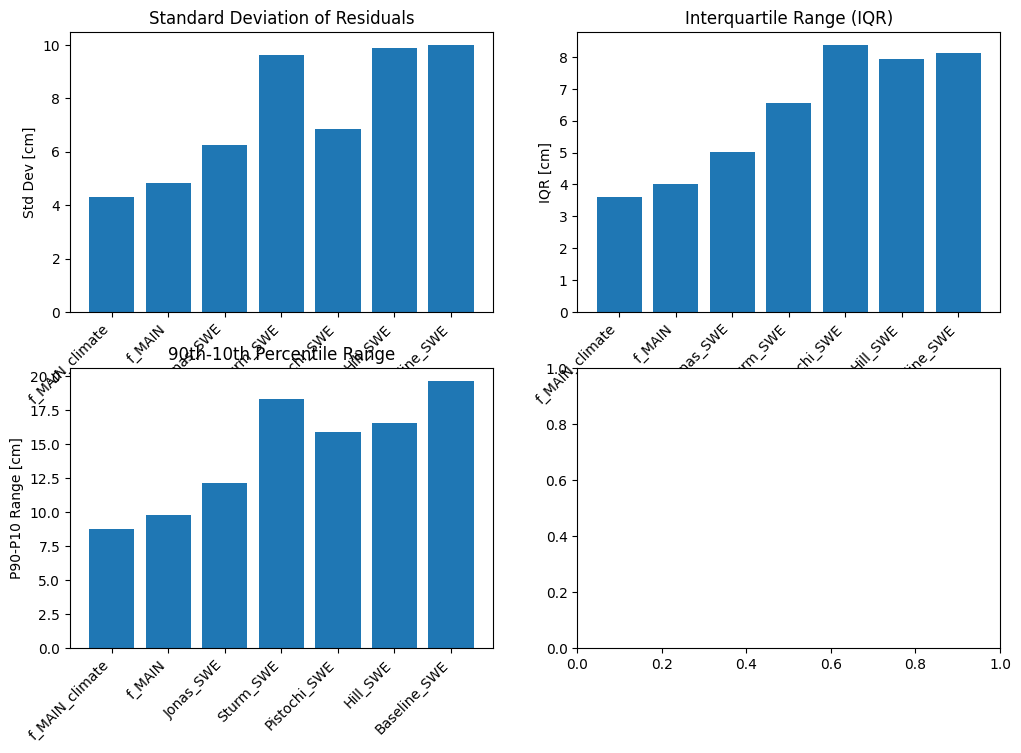

In [56]:
plot_distribution_widths(swe_df_for_evals)

In [46]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from scipy.stats import skew

# fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10, 20))

# for i, model in enumerate(swe_df_for_evals.columns[:-1]):

#     if model == 'LGBM_SWE':
#         y_label = '$f_{MAIN}$' + ' SWE [cm]'
#     elif model == 'LGBM_SWE_climate':
#         y_label = '$f_{CLIMATE}$' + ' SWE [cm]'
#     elif 'Jonas' in model:
#         y_label = 'Jonas et al. (2009)' + ' SWE [cm]'
#     elif 'Sturm' in model:
#         y_label = 'Sturm et al. (2010)' + ' SWE [cm]'
#     elif 'Pistochi' in model:
#         y_label = 'Pistocchi (2016)' + ' SWE [cm]' 
#     elif 'Hill' in model:
#         y_label = 'Hill (2019)' + ' SWE [cm]'
#     else:
#         y_label = model.split('_')[0] + ' SWE [cm]'

#     # Left panel: hexbin plot
#     hb = ax[i, 0].hexbin(swe_df_for_evals.Observed_SWE, swe_df_for_evals[model], 
#                          gridsize=80, cmap='magma', bins='log', mincnt=3)
#     ax[i, 0].plot([0,1], [0,1], transform=ax[i, 0].transAxes, color='k')
#     ax[i, 0].set_xlabel('Observed SWE [cm]', fontsize=14)
#     ax[i, 0].set_ylabel(y_label, fontsize=12)
#     ax[i, 0].set(xlim=(-10, 280), ylim=(-10, 280))
#     ax[i, 0].text(0.10, 0.90, f'{chr(96+(2*i + 1))})', 
#                   transform=ax[i, 0].transAxes, fontsize=18, va='top', ha='right')
#     cb = plt.colorbar(hb, ax=ax[i, 0])
#     cb.set_label('counts in bin', fontsize=15)

#     # Right panel: residual histogram with skewness and kurtosis
#     residuals = swe_df_for_evals[model] - swe_df_for_evals.Observed_SWE
#     residual_skewness = skew(residuals.dropna())
#     residual_kurtosis = kurtosis(residuals.dropna(), fisher=True)
    
#     sns.histplot(residuals, kde=True, stat='probability', bins=150, ax=ax[i, 1])
#     ax[i, 1].lines[0].set_color('crimson')
#     ax[i, 1].set_xlabel('Residual [cm]', fontsize=14)
#     ax[i, 1].set_ylabel('Probability', fontsize=14)
#     ax[i, 1].set(xlim=(-25, 25))
#     ax[i, 1].text(0.10, 0.90, f'{chr(96+(2*i + 2))})', 
#                   transform=ax[i, 1].transAxes, fontsize=18, va='top', ha='right')
    
#     # Add skewness and kurtosis text
#     stats_text = f'Skew: {residual_skewness:.3f}\nKurt: {residual_kurtosis:.3f}'
#     ax[i, 1].text(0.95, 0.90, stats_text, 
#                   transform=ax[i, 1].transAxes, fontsize=11, 
#                   va='top', ha='right', 
#                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
#     ax[i, 1].tick_params(labelsize=11)

# plt.tight_layout()
# # plt.savefig('../plots/figure8.jpg', dpi=300, bbox_inches='tight')
# plt.show()

In [28]:
for snow_class in all_swe_predictions.Snow_Class.unique():

    # Filter the DataFrame for the current snow class and drop NaNs
    if snow_class != "Ephemeral":
        swe_df_for_evals_ = (
            all_swe_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'Observed_SWE', 'LGBM_SWE_climate', 'LGBM_SWE',
                'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE', 'Baseline_SWE'
            ])
            .dropna()
        )

    else:
        swe_df_for_evals_ = (
            all_swe_predictions.query("Snow_Class == @snow_class")
            .filter(items=[
                'Observed_SWE', 'LGBM_SWE_climate', 'LGBM_SWE',
                'Jonas_SWE', 'Pistochi_SWE', 'Hill_SWE', 'Baseline_SWE'
            ])
            .dropna()
        )

    # Calculate the size and percentage of the test set
    size = swe_df_for_evals_.shape[0]
    total_size = all_swe_predictions.dropna().shape[0] + all_swe_predictions.query("Snow_Class == 'Ephemeral'").drop('Sturm_SWE', axis=1).dropna().shape[0]
    percentage = round(size / total_size * 100, 1)

    # Print the snow class and the size of the test set
    print(f"Snow Class: {snow_class}, Test Set Size: {size} ({percentage}%)")
    
    swe_rslts=compare_multiple_models(preds_df=swe_df_for_evals_, y_true="Observed_SWE")

    if snow_class == "Ephemeral":
        display(swe_rslts.assign(Sturm_SWE='N/A'))
    # swe_rslts.to_csv(f'../results/swe/{snow_class}_model_eval.csv', index=True)

    # Display the results of comparing multiple models
    else:
        display(swe_rslts)  

Snow Class: Prairie, Test Set Size: 37500 (8.3%)


,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE
RMSE,3.424039,3.703752,4.450046,6.005010,7.988798,6.314137,6.866714
MBE,0.577388,0.387841,-0.369080,2.499155,5.781875,3.947464,0.375384
RSQ,0.964099,0.957993,0.939360,0.889577,0.804568,0.877915,0.855612


Snow Class: Alpine, Test Set Size: 263015 (57.9%)


,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE
RMSE,4.050792,4.489130,5.759304,6.667418,8.870980,9.246620,9.021583
MBE,0.293803,0.268342,0.049809,2.381802,6.361148,5.642657,-0.573031
RSQ,0.973987,0.968053,0.947416,0.929527,0.875246,0.864457,0.870975


Snow Class: Ephemeral, Test Set Size: 12315 (2.7%)


,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE,Sturm_SWE
RMSE,3.420351,3.845111,5.335019,4.905568,7.428519,6.052172,N/A
MBE,-0.099789,0.002951,-2.979101,2.004496,4.181797,-1.790976,N/A
RSQ,0.953945,0.941796,0.887950,0.905264,0.782759,0.855802,N/A


Snow Class: Maritime, Test Set Size: 28024 (6.2%)


,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE
RMSE,8.187774,9.131229,12.346275,10.639791,9.904026,31.659622,20.995637
MBE,-0.165467,0.003014,-5.265928,-0.434003,1.147438,19.746451,-11.406377
RSQ,0.961375,0.951961,0.912178,0.934777,0.943486,0.422509,0.746025


Snow Class: Taiga, Test Set Size: 105296 (23.2%)


,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE
RMSE,3.901201,4.451384,5.553859,15.298573,11.624400,9.950720,9.067264
MBE,0.443716,0.366591,1.914803,-9.135326,9.313790,7.046197,0.119888
RSQ,0.974118,0.966303,0.947544,0.601979,0.770203,0.831611,0.860184


Snow Class: Tundra, Test Set Size: 8188 (1.8%)


,LGBM_SWE_climate,LGBM_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,Hill_SWE,Baseline_SWE
RMSE,2.468715,2.540573,5.102605,3.978289,8.640164,5.388025,4.891122
MBE,-0.135302,-0.168992,3.180080,2.237767,7.176803,2.272758,3.254774
RSQ,0.944577,0.941303,0.763225,0.856072,0.321116,0.735996,0.782445


In [37]:
swe_for_boxplot=(
    all_swe_predictions
    .filter(items=[
        'Observed_SWE', 'LGBM_SWE_climate', 'LGBM_SWE', 'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE', 'Snow_Class'  
    ])
    .dropna(subset=['LGBM_SWE_climate', 'Jonas_SWE', 'Hill_SWE'])
    .melt(id_vars=['Snow_Class'], value_vars=['Observed_SWE', 'LGBM_SWE_climate', 'LGBM_SWE', 'Jonas_SWE', 'Sturm_SWE', 'Pistochi_SWE', 'Hill_SWE',], var_name='Model', value_name='SWE')
    .replace({
        'LGBM_SWE_climate': '$f_{CLIMATE}$', 'LGBM_SWE': '$f_{MAIN}$', 'Observed_SWE': 'Observed',
        'Hill_SWE': 'Hill (2019)', 'Pistochi_SWE': 'Pistocchi (2016)', 'Sturm_SWE': 'Sturm et al. (2010)', 'Jonas_SWE': 'Jonas et al. (2009)'
    })
)

swe_for_boxplot.head()

,Snow_Class,Model,SWE
0,Prairie,Observed,24.130
1,Prairie,Observed,24.384
2,Prairie,Observed,25.146
3,Prairie,Observed,25.654
4,Prairie,Observed,26.162


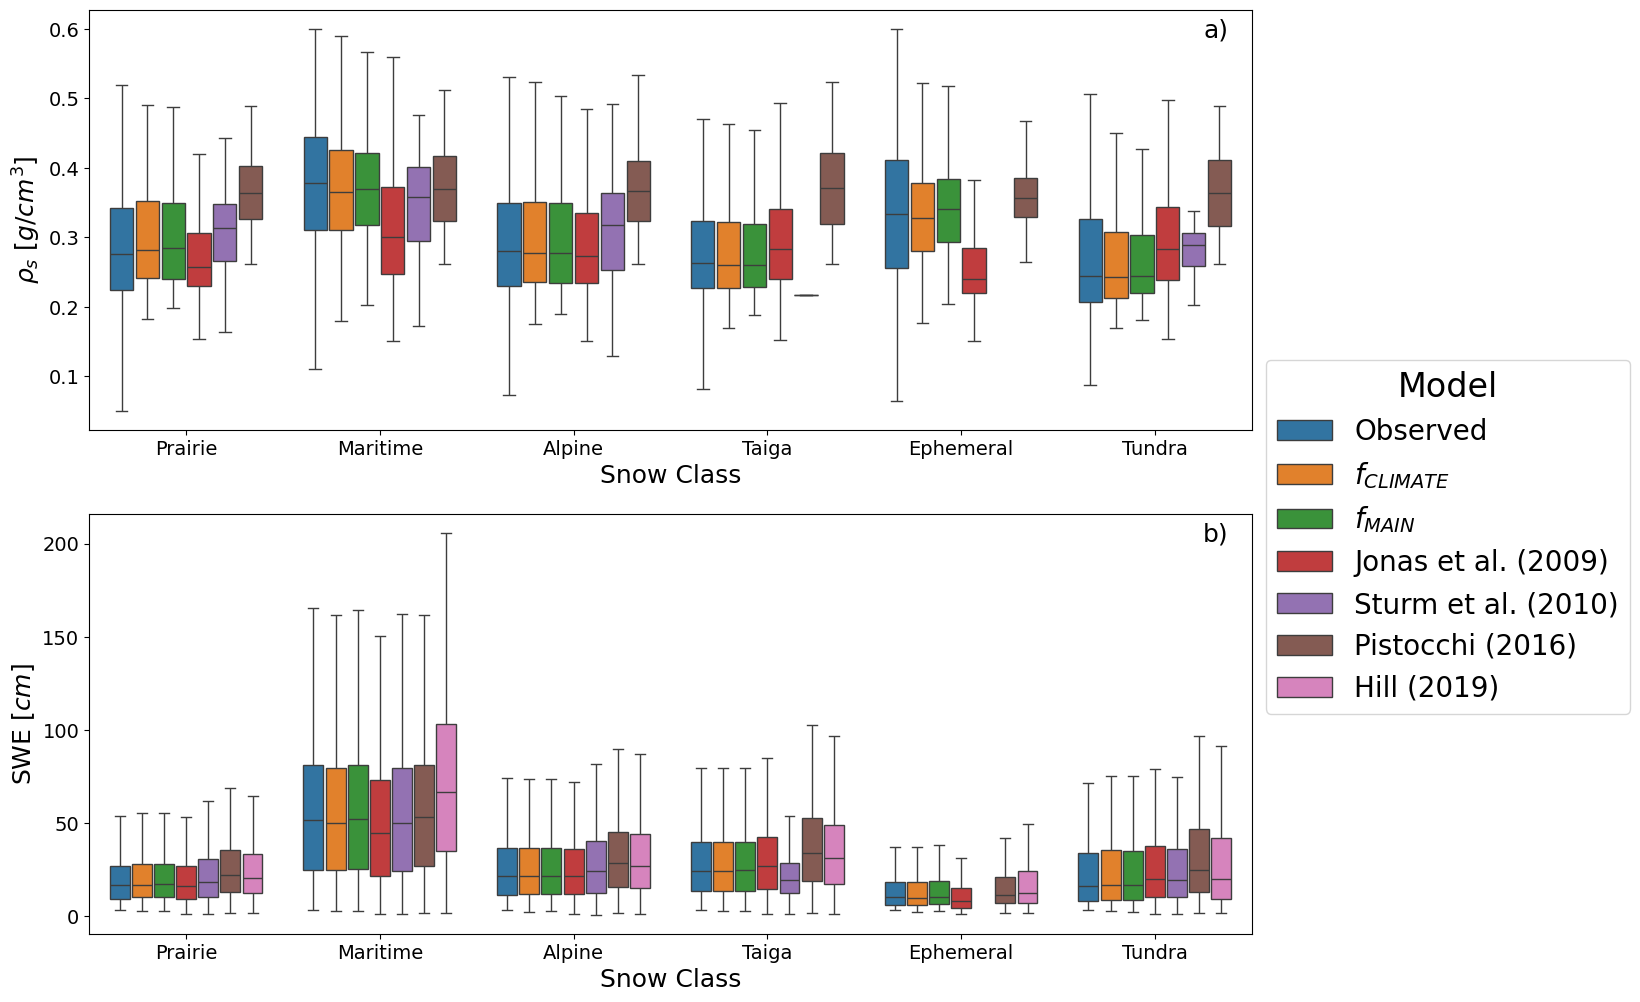

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.boxplot(data=density_for_boxplot, x='Snow_Class', y='Density', hue='Model', ax=ax[0], fill=True, gap=.1, showfliers = False)
ax[0].set_xlabel('Snow Class', fontsize=18)
ax[0].set_ylabel(r'$\rho_s\ [g/cm^3]$', fontsize=18)
ax[0].legend([], frameon=False)
ax[0].tick_params(labelsize=14)
ax[0].text(0.98, 0.98, 'a)', transform=ax[0].transAxes, fontsize=18, va='top', ha='right')


sns.boxplot(data=swe_for_boxplot, x='Snow_Class', y='SWE', hue='Model', ax=ax[1], fill=True, gap=.1, showfliers = False)
ax[1].set_xlabel('Snow Class', fontsize=18)
ax[1].set_ylabel('SWE $[cm]$', fontsize=18)
legend=ax[1].legend(title='Model', fontsize=20, bbox_to_anchor=(1.0, 1.4))
legend.get_title().set_fontsize(24)
ax[1].tick_params(labelsize=14)
ax[1].text(0.98, 0.98, 'b)', transform=ax[1].transAxes, fontsize=18, va='top', ha='right')


# plt.savefig('../plots/figure9.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

In [54]:
xgb_main = xgb.Booster()
xgb_main.load_model("../ML_weights/main_density_model.ubj")  # Load model from Uiversal Binary JSON file

In [55]:
xgb_climate = xgb.Booster()
xgb_climate.load_model("../ML_weights/climate_density_model.ubj")

### Impurity-based Importance

In [56]:
xgboost_gain_main=(
    pd.DataFrame(
        data={
            "Feature": xgb_main.feature_names,
            "Importance": xgb_main.get_score(importance_type='gain').values()
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',

    })
)

xgboost_gain_main

,Feature,Importance
3,Snow Class,0.240515
2,DOWY,0.114483
0,Elevation,0.030825
1,Snow Depth,0.024226


In [58]:
xgboost_gain_climate=(
    pd.DataFrame(
        data={
            "Feature": xgb_climate.feature_names,
            "Importance": xgb_climate.get_score(importance_type='gain').values()
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
        'TAVG_lag_14d': r'$\bar{t}_{-14}$',
        'PRECIPITATION_lag_14d': r'$\bar{p}_{-14}$'
    })
)

xgboost_gain_climate

,Feature,Importance
5,Snow Class,0.070327
2,DOWY,0.053497
1,Snow Depth,0.014610
3,$\bar{t}_{-14}$,0.011647
0,Elevation,0.010552
4,$\bar{p}_{-14}$,0.005069


### SHAP Importance

In [60]:
X_train_raw = data_splits['X_temp'] # train + val instances
X_test_raw = data_splits['X_test']
y_train = data_splits['y_temp']
y_test = data_splits['y_test']

In [61]:
with open('../ML_weights/encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

# Use the loaded encoder
new_X_cat = loaded_encoder.transform(X_test_raw['Snow_Class'])
X_test_main = pd.concat([X_test_raw[['Elevation', 'Snow_Depth', 'DOWY']], new_X_cat], axis=1)

In [ ]:
## Calculate SHAP values for the density model
xgb_main.set_param({"device": "cuda:0"}) ## comment this out if you do not have a GPU
explainer = shap.TreeExplainer(xgb_main)
shap_values_main = explainer.shap_values(X_test_main)

In [63]:
shap_importance_main=(
    pd.DataFrame(
        data={
            "Feature": xgb_main.feature_names,
            "Importance": np.abs(shap_values_main).mean(axis=0)
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow Depth': 'Snow Depth',
    })
)

shap_importance_main

,Feature,Importance
2,DOWY,0.054588
0,Elevation,0.016786
3,Snow Class,0.015857
1,Snow_Depth,0.013277


In [64]:
with open('../ML_weights/encoder_climate.pkl', 'rb') as f:
    loaded_encoder_climate = pickle.load(f)


X_test_raw_climate=X_test_raw.dropna(subset = ['TAVG_lag_14d', 'PRECIPITATION_lag_14d'])

# Use the loaded encoder
new_X_cat_climate = loaded_encoder_climate.transform(X_test_raw_climate['Snow_Class'])
X_test_climate = pd.concat([X_test_raw_climate[['Elevation', 'Snow_Depth', 'DOWY','TAVG_lag_14d', 'PRECIPITATION_lag_14d']], new_X_cat_climate], axis=1)

In [65]:
## Calculate SHAP values for the density model
xgb_climate.set_param({"device": "cuda:3"}) ## comment this oit if you do not have a GPU
explainer = shap.TreeExplainer(xgb_climate)
shap_values_climate = explainer.shap_values(X_test_climate)

In [67]:
shap_importance_climate=(
    pd.DataFrame(
        data={
            "Feature": xgb_climate.feature_names,
            "Importance": np.abs(shap_values_climate).mean(axis=0)
        }
    )
    .sort_values(by="Importance", ascending=False)
    .replace({
        'Snow_Class': 'Snow Class',
        'Snow_Depth': 'Snow Depth',
        'TAVG_lag_14d': r'$\bar{t}_{-14}$',
        'PRECIPITATION_lag_14d': r'$\bar{p}_{-14}$'
    })
)

shap_importance_climate

,Feature,Importance
2,DOWY,0.045380
3,$\bar{t}_{-14}$,0.018629
1,Snow Depth,0.016800
5,Snow Class,0.011944
0,Elevation,0.011691
4,$\bar{p}_{-14}$,0.005920


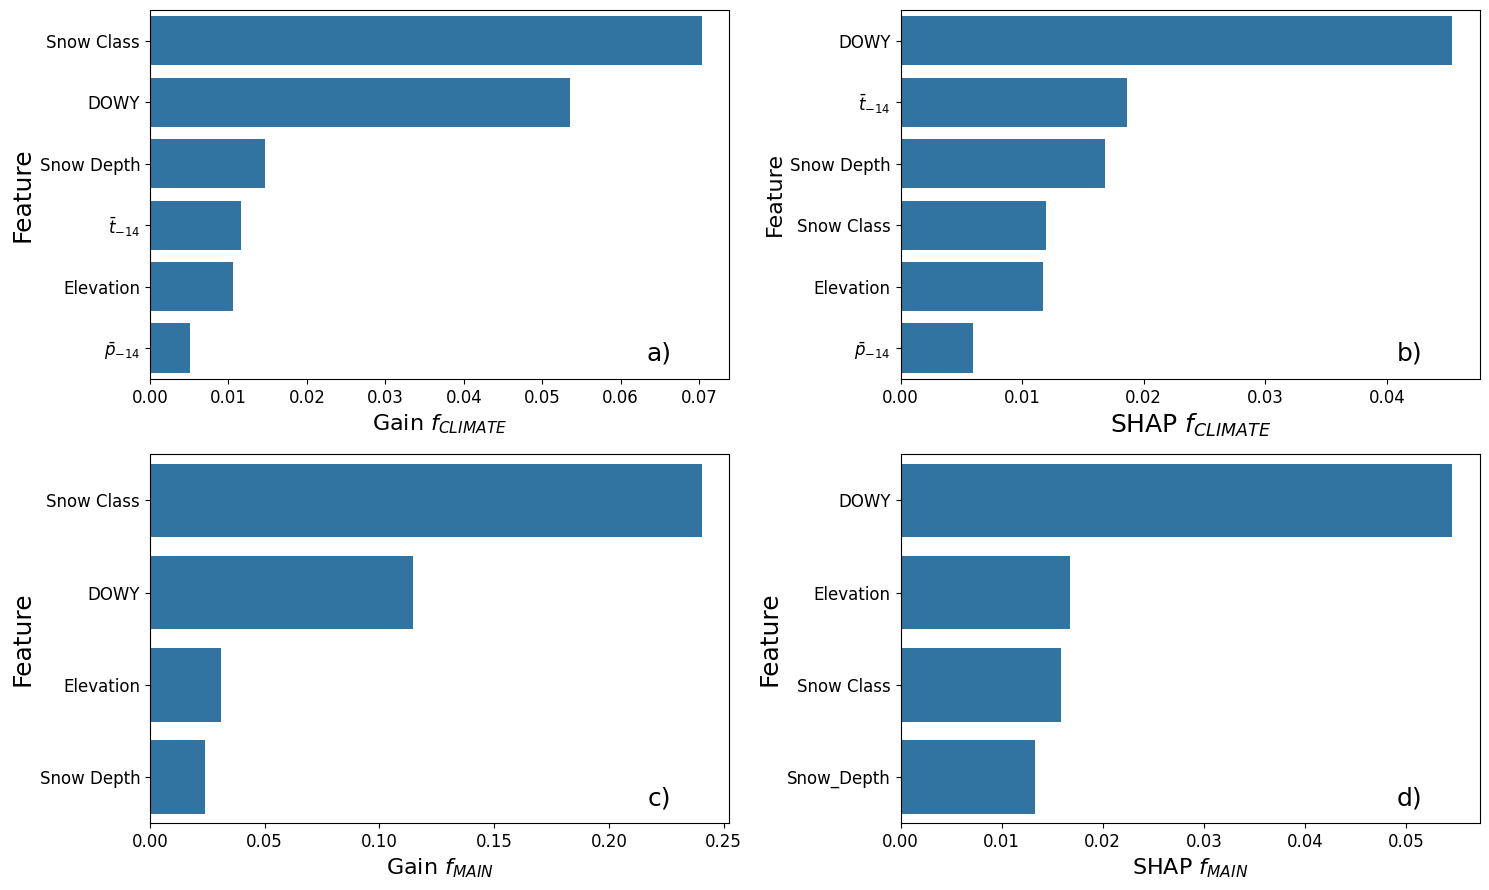

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

sns.barplot(x="Importance", y="Feature", data=xgboost_gain_climate, ax=ax[0, 0])
ax[0, 0].set_xlabel("Gain $f_{CLIMATE}$", fontsize=16)
ax[0, 0].set_ylabel("Feature", fontsize=18)
ax[0, 0].tick_params(labelsize=12)
ax[0, 0].text(0.90, 0.10, 'a)', transform=ax[0, 0].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=shap_importance_climate, ax=ax[0, 1])
ax[0, 1].set_xlabel("SHAP $f_{CLIMATE}$", fontsize=18)
ax[0, 1].set_ylabel("Feature", fontsize=16)
ax[0, 1].tick_params(labelsize=12)
ax[0, 1].text(0.90, 0.10, 'b)', transform=ax[0, 1].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=xgboost_gain_main, ax=ax[1, 0])
ax[1, 0].set_xlabel("Gain $f_{MAIN}$", fontsize=16)
ax[1, 0].set_ylabel("Feature", fontsize=18)
ax[1, 0].tick_params(labelsize=12)
ax[1, 0].text(0.90, 0.10, 'c)', transform=ax[1, 0].transAxes, fontsize=18, va='top', ha='right')



sns.barplot(x="Importance", y="Feature", data=shap_importance_main, ax=ax[1, 1])
ax[1, 1].set_xlabel("SHAP $f_{MAIN}$", fontsize=16)
ax[1, 1].set_ylabel("Feature", fontsize=18)
ax[1, 1].tick_params(labelsize=12)
ax[1, 1].text(0.90, 0.10, 'd)', transform=ax[1, 1].transAxes, fontsize=18, va='top', ha='right')

plt.tight_layout()
plt.savefig('../plots/figure10.jpg', dpi=300, bbox_inches='tight')
plt.show()